In [2]:
import sys
import os
sys.path.append(os.pardir)
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist
import copy

In [3]:
def mean_squad_error(yhat, y):
    return 0.5 * np.sum((yhat-y)**2)

In [4]:
y = np.array([0,0,1,0,0,0,0,0,0,0])
yhat = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])

In [5]:
mean_squad_error(yhat, y)

0.09750000000000003

In [6]:
x = np.arange(0.1, 1.1, 0.1)
y_ = np.log(x)

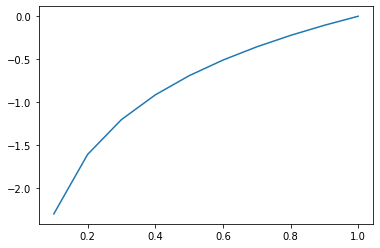

In [7]:
plt.plot(x,y_)

In [8]:
def cross_entropy_error(yhat, y):
    delta = 1e-7
    return -np.sum(y * np.log(yhat + delta))

In [9]:
cross_entropy_error(yhat, y)

0.510825457099338

In [10]:
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

In [11]:
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000, 10)


In [12]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
y_batch = y_train[batch_mask]

In [13]:
from mpl_toolkits.mplot3d import Axes3D

In [14]:
def squad(x):
    return x[0]**2 + x[1]**2

In [15]:
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)

In [16]:
X, Y = np.meshgrid(x, y)
Z = squad([X,Y])

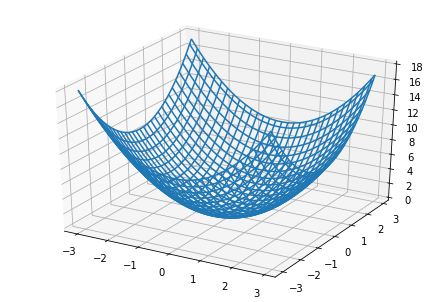

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z)
plt.show()

In [18]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

In [19]:
numerical_gradient(squad, np.array([3.0, 4.0]))

array([6., 8.])

In [20]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_all = []
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        t = copy.deepcopy(x)
        x_all.append(t)
        
    return x_all

In [21]:
init_x =  np.array([-3.0, 4.0])

In [22]:
d = gradient_descent(squad, init_x, 0.1)

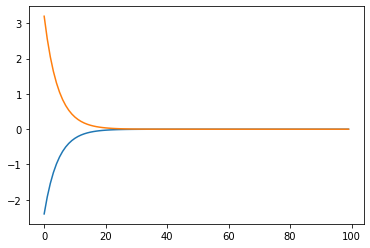

In [23]:
plt.plot(d)

In [24]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

In [25]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.04918366  0.08310728 -0.13229094]
 [ 0.07377549  0.12466092 -0.19843641]]


In [26]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

In [27]:
x = np.random.rand(100, 784)
y = np.random.rand(100, 10)

In [31]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [32]:
grads = net.numerical_gradient(x, y)

## ミニバッチ学習の実装

train acc, test acc | 0.09751666666666667, 0.0974
train acc, test acc | 0.7935833333333333, 0.7952
train acc, test acc | 0.8789, 0.8829
train acc, test acc | 0.8983, 0.9011
train acc, test acc | 0.9069333333333334, 0.9099
train acc, test acc | 0.9146, 0.9148
train acc, test acc | 0.9189833333333334, 0.9197
train acc, test acc | 0.9233166666666667, 0.9241
train acc, test acc | 0.92625, 0.9278
train acc, test acc | 0.9302, 0.9301
train acc, test acc | 0.9339333333333333, 0.9346
train acc, test acc | 0.9357833333333333, 0.936
train acc, test acc | 0.9387, 0.9393
train acc, test acc | 0.94075, 0.9395
train acc, test acc | 0.9422, 0.9411
train acc, test acc | 0.9446333333333333, 0.9421
train acc, test acc | 0.9458, 0.9444


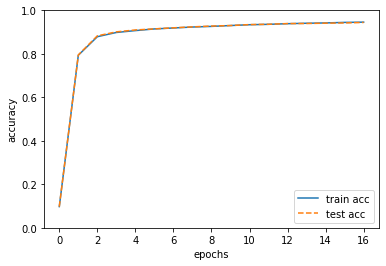

In [36]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

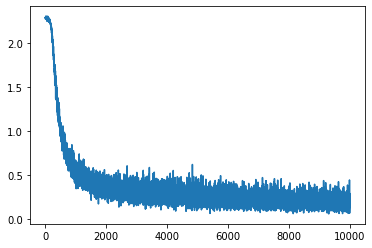

In [39]:
plt.plot(train_loss_list)